# Aprendizaje automático en grafos

Código realizado por:
* _Pablo Santos Pérez_
* _Jesús Martín Vergara_

## Librerías

Importamos las librerías necesarias para el proyecto

In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection, preprocessing, neighbors, naive_bayes, tree
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.metrics import log_loss
from matplotlib import pyplot as plt
import networkx as nx
import networkx.algorithms.community as nx_comm
import seaborn as sns

## Lectura de datos

Leemos los datos del CSV donde data va a contener los datos de los atributos.

In [2]:
data = pd.read_csv('./CSV/BAAD_ATTR.csv')

También leemos los datos relacionales obviando la primera fila y columna correspondiente a los nombres de las organizaciones.

In [3]:
data_relation = pd.read_csv('./CSV/BAAD_1M.csv', header=None)
relation = data_relation.iloc[1:,1:]

Vemos el tamaño de los datos, tanto filas como columnas

In [4]:
print(data.shape)

(394, 17)


Comprobamos que la lectura del CSV es correcta.

In [5]:
data.head(10)

,Name,fatalities19982005,statespond,masterccode,OrgAge,ContainRelig,ContainEthno,LeftNoReligEthno,ordsize,PureRelig,PureEthno,ReligEthno,ContainRelig2,ContainEthno2,islam,degree,terrStrong
0,15-May,0,0,350,8,0,0,1,0,0,0,0,0,0,0,3,0
1,1920_Revolution_Brigades,0,0,645,3,1,1,0,0,0,0,1,0,0,1,1,0
2,21-Jun,0,0,350,3,0,0,0,0,0,0,0,0,0,0,0,0
3,Abdurajak_Janjalani_Brigade(AJB),0,0,840,7,0,0,0,0,0,0,0,0,0,0,1,0
4,Abu_Bakr_al-Siddiq_Fundamentalist_Brigades,0,0,645,2,1,0,0,0,1,0,0,1,0,1,0,0
5,Abu_Hafs_al-Masri_Brigade,193,0,200,5,1,0,0,0,1,0,0,1,0,1,2,0
6,Abu_Nayaf_al-Afgani,0,0,230,2,1,0,0,0,1,0,0,1,0,1,2,0
7,Abu_Sayyaf_Group(ASG),186,0,840,15,1,1,0,1,0,0,1,0,0,1,4,1
8,Abu_al-Abbas,0,0,645,2,1,0,0,0,1,0,0,1,0,1,1,0
9,Abu_al-Rish_Brigades,0,0,666,13,0,1,0,0,0,1,0,0,1,0,2,0


Definimos cuáles van a ser los atributos a usar y el objetivo a predecir. En este caso el objetivo será si una organización terrorista es islámica o no. El resto de atributos, exceptuando el nombre seran los que se tendrán en cuenta para la predicción.

In [6]:
atributos = data.loc[:, ["fatalities19982005","statespond","masterccode","OrgAge","ContainRelig","ContainEthno","LeftNoReligEthno","ordsize","PureRelig","PureEthno", "ReligEthno", "ContainRelig2", "ContainEthno2", "degree", "terrStrong"]]
objetivo = data["islam"]

Codificamos los datos para que nos permita trabajar con el array completo de valores de los atributos. El codificador adecuado para esto es OrdinalEncoder. Luego se ajusta a los datos disponibles mediante el método fit.

In [7]:
codificador_atributos = preprocessing.OrdinalEncoder()
codificador_atributos.fit(atributos)

atributos_codificados = codificador_atributos.transform(atributos)

Se hace lo mismo con el objetivo pero esta vez con LabelEncoder para usar un array unidimensional.

In [8]:
codificador_objetivo = preprocessing.LabelEncoder()
objetivo_codificado = codificador_objetivo.fit_transform(objetivo)

Las clases detectadas por el codificador para la variable objetivo son 0 y 1, siendo 0 no islámica y 1 islámica

In [9]:
print(codificador_objetivo.classes_)

[0 1]


Ahora vamos a empezar con los datos relacionales. Creamos un grafo con los datos e informacion relacional. 
Al crear el grafo, cada nodo está relacionado consigo mismo, es decir la matriz diagonal es 1 por lo que creamos una matriz identidad del tamaño de la matriz de los datos, que al restarla a la matriz del grafo, evitará que se produzcan lazos en el mismo.

In [10]:
m=np.identity(relation.shape[0])

De la misma forma que los datos anteriores hacemos una codificación de los datos relacionales.

In [11]:
codificador_adyacencias = preprocessing.OrdinalEncoder()
codificador_adyacencias.fit(relation.values)
adyacencias_codificadas = codificador_adyacencias.transform(relation.values)-m #restamos la identidad
print(adyacencias_codificadas)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Creamos el grafo y lo visualizamos con las opciones que hemos creído convenientes para su mejor observación.

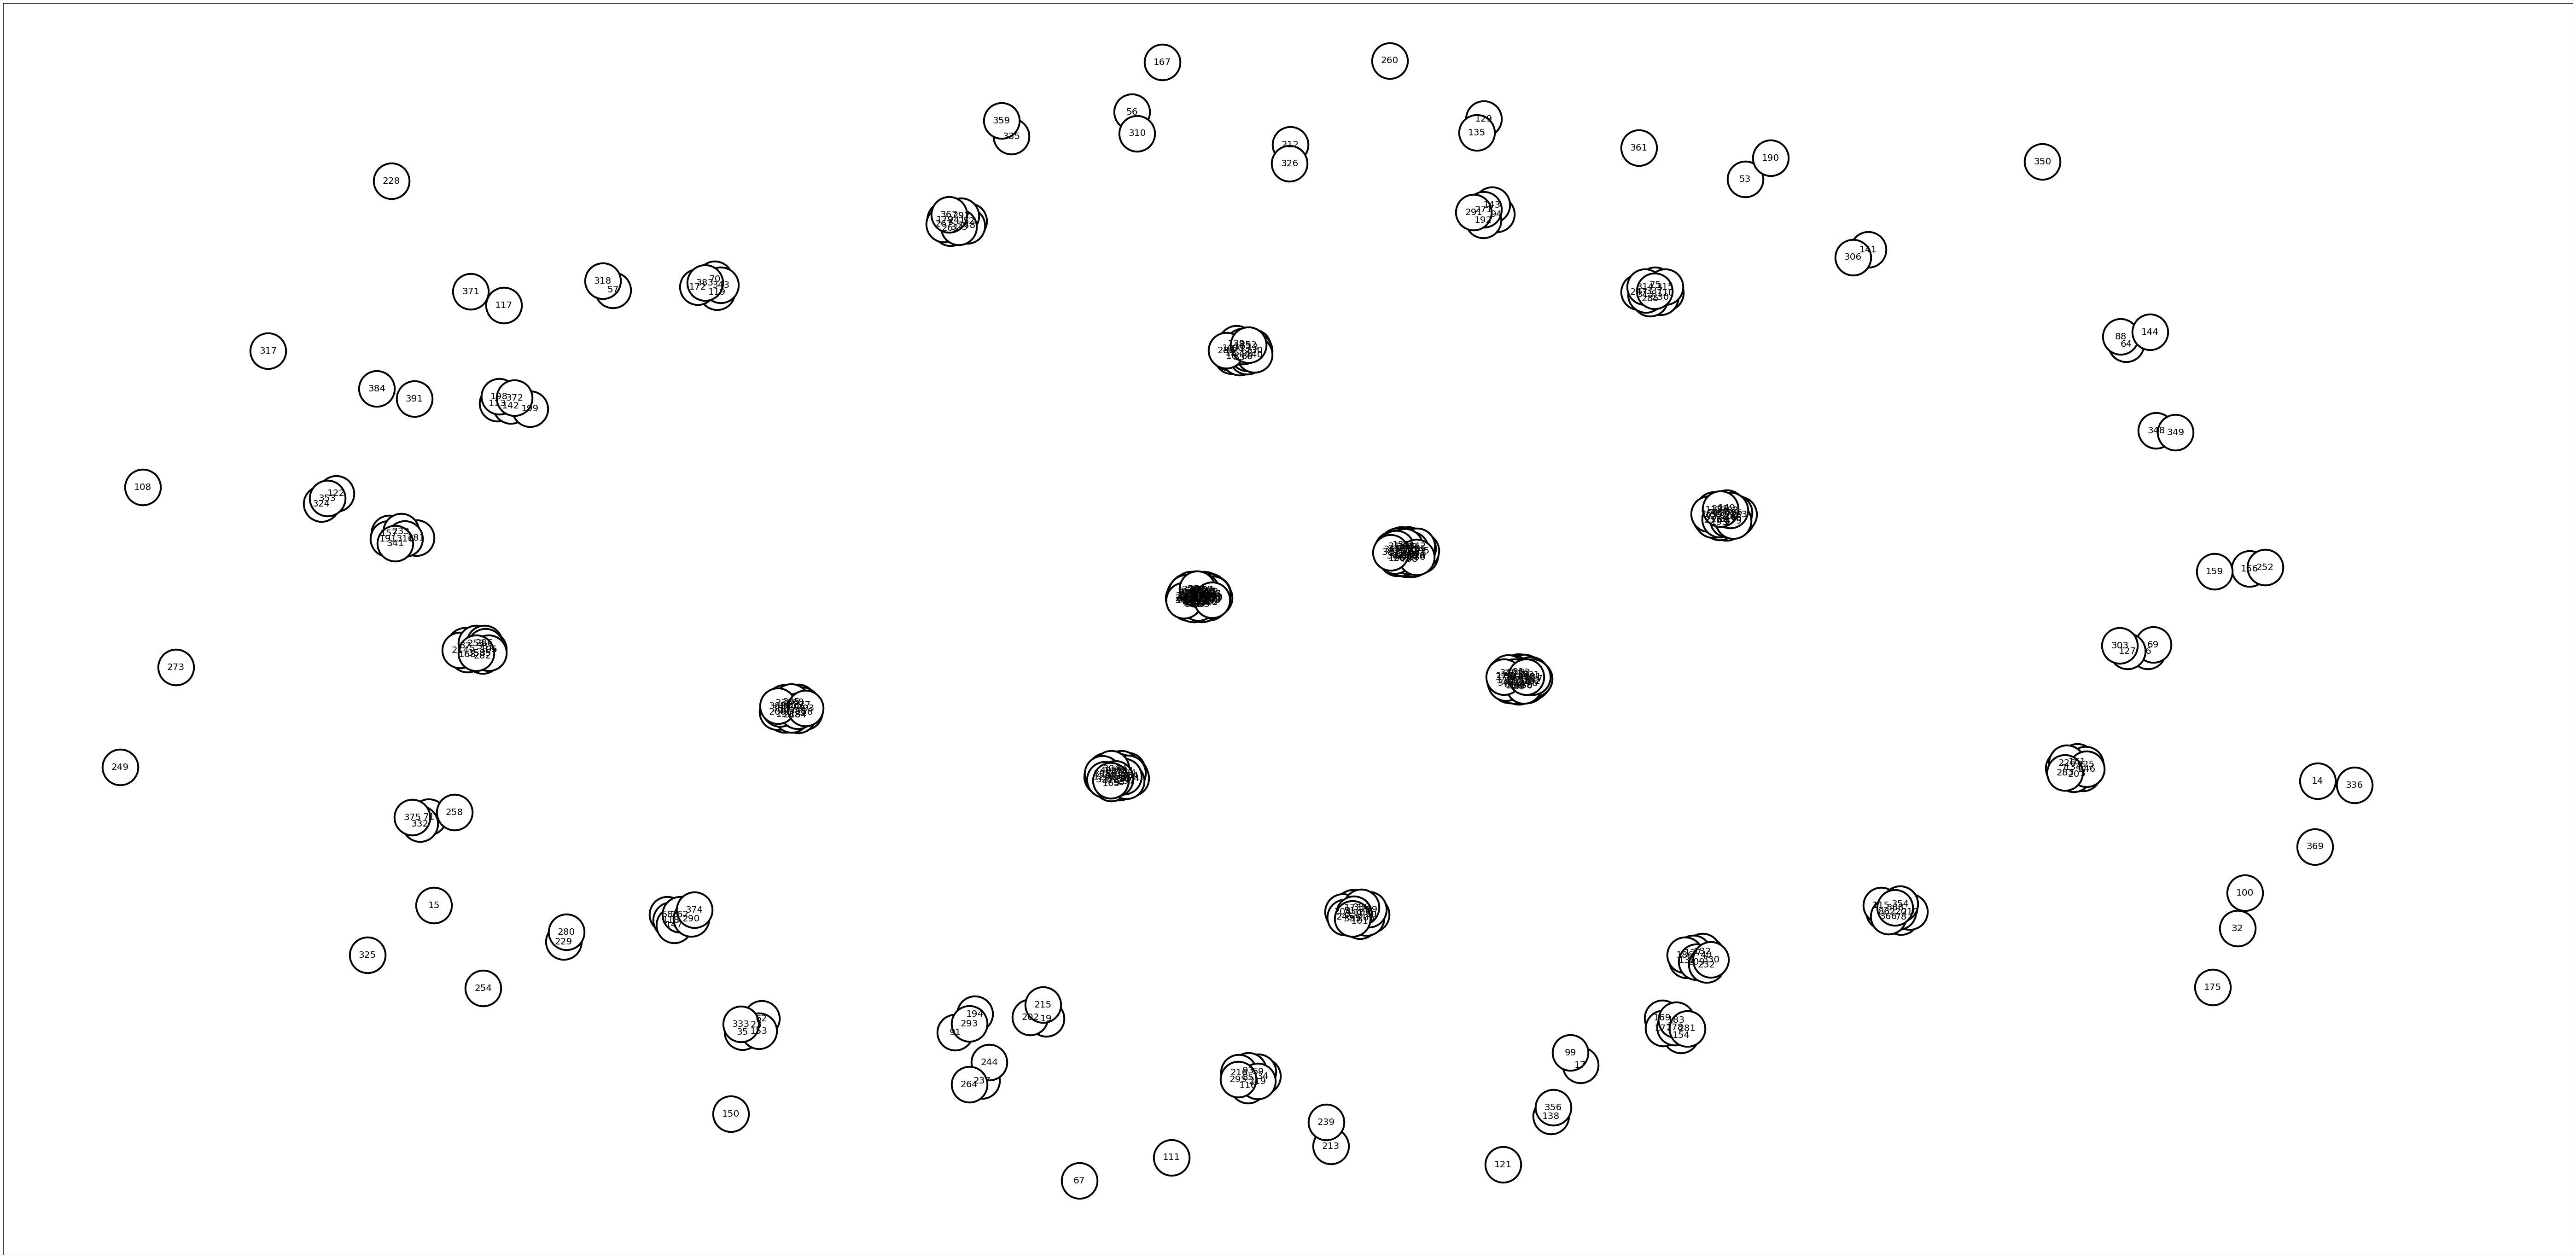

In [12]:
G = nx.from_numpy_matrix(adyacencias_codificadas)
plt.figure(3,figsize=(100,50)) 
options = {
    "font_size": 20,
    "node_size": 6000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 4,
    "width": 1,
}
nx.draw_networkx(G, **options)
plt.show()

## Definición de funciones y atributos

Ahora obtendremos los atributos de entrenamiento y validación,y a su vez, los objetivos de entrenamiento y validación, siendo los de entrenamiento un 67% del total de los datos. Lo haremos creando una funcion, ya que más tarde será necesaria.

In [13]:
def entrenamiento(att, obj):
    (atributos_entrenamiento, atributos_validacion, objetivo_entrenamiento, objetivo_validacion) = model_selection.train_test_split(
            att, obj,
            random_state=12345,
            test_size=.33,
            stratify=objetivo_codificado)
    return (atributos_entrenamiento, atributos_validacion, objetivo_entrenamiento, objetivo_validacion)

In [14]:
(atributos_entrenamiento, atributos_validacion,
 objetivo_entrenamiento, objetivo_validacion) = entrenamiento(atributos_codificados, objetivo_codificado)

Comprobamos que el conjunto de validación contiene el 33 % de los datos, en la misma proporción
con respecto a la variable objetivo

In [15]:
print('Cantidad de ejemplos de validación requeridos:', data.shape[0] * .33)
print('\nFilas del array de atributos de validación:', atributos_validacion.shape[0])
print('\nLongitud del vector de objetivos de validación:', len(objetivo_validacion))
print('\nProporción de clases en el vector de objetivos de validación:')

no_islamica = pd.Series(
        codificador_objetivo.inverse_transform(objetivo_validacion)
      ).value_counts(normalize=True)[0]
es_islamica = pd.Series(
        codificador_objetivo.inverse_transform(objetivo_validacion)
      ).value_counts(normalize=True)[1]
print(f"\nEl {round(es_islamica*100, 4)}% de las organizaciones son islámicas")
print(f"El {round(no_islamica*100, 4)}% de las organizaciones no son islámicas")


Cantidad de ejemplos de validación requeridos: 130.02

Filas del array de atributos de validación: 131

Longitud del vector de objetivos de validación: 131

Proporción de clases en el vector de objetivos de validación:

El 27.4809% de las organizaciones son islámicas
El 72.5191% de las organizaciones no son islámicas


Comprobamos que el conjunto de entrenamiento contiene el resto de los datos, en la misma
proporción con respecto a la variable objetivo

In [16]:
print('Cantidad de ejemplos de entrenamiento requeridos:', data.shape[0] * .67)
print('\nFilas del array de atributos de entrenamiento:', atributos_entrenamiento.shape[0])
print('\nLongitud del vector de objetivos de entrenamiento:', len(objetivo_entrenamiento))

no_islamica = pd.Series(
        codificador_objetivo.inverse_transform(objetivo_entrenamiento)
      ).value_counts(normalize=True)[0]
es_islamica = pd.Series(
        codificador_objetivo.inverse_transform(objetivo_entrenamiento)
      ).value_counts(normalize=True)[1]
print(f"\nEl {round(es_islamica*100, 4)}% de las organizaciones son islamica")
print(f"El {round(no_islamica*100, 4)}% de las organizaciones no son islamica")

Cantidad de ejemplos de entrenamiento requeridos: 263.98

Filas del array de atributos de entrenamiento: 263

Longitud del vector de objetivos de entrenamiento: 263

El 26.9962% de las organizaciones son islamica
El 73.0038% de las organizaciones no son islamica


Definimos las funciones necesarias para aplicar los modelos.

Definimos una función KNn para aplicar el modelo de K Nearest neighbor cuyos parametros son neighbor(numero de vecinos), metrica(la metrica usada), att(conjunto de atributos de entramiento), obj(conjunto de objetivos de entrenamiento) y ejemplos(contiene los nuevos ejemplos a predecir).

In [17]:
def KNn(neighbor, metrica, att, obj):
    (atributos_entrenamiento, atributos_validacion,
    objetivo_entrenamiento, objetivo_validacion) = entrenamiento(att,obj)
    
    clasif_kNN = neighbors.KNeighborsClassifier(n_neighbors=neighbor,metric=metrica)
    clasif_kNN.fit(atributos_entrenamiento, objetivo_entrenamiento)
    print(f"Eficiencia: {round(clasif_kNN.score(atributos_validacion, objetivo_validacion), 10)*100}%")

La funcion naive corresponde al modelo de Naive Bayes cuyos parámetros son att(conjunto de atributos de entrenamiento), obj(conjunto de objetivos de entrenamiento) y ejemplos(contiene los nuevos ejemplos a predecir).

In [18]:
def naive(att, obj):
    (atributos_entrenamiento, atributos_validacion,
    objetivo_entrenamiento, objetivo_validacion) = entrenamiento(att,obj)
    clasif_NB = naive_bayes.CategoricalNB(alpha=1.0)  # alpha es el parámetro de suavizado
    clasif_NB.fit(atributos_entrenamiento, objetivo_entrenamiento)
    print(f"Eficiencia: {round(clasif_NB.score(atributos_validacion, objetivo_validacion), 10)*100}%")

La funcion cart sirve para modelar un Árbol de decision y a partir de el conseguir una predicción de un ejemplo dado cuyos parámetros son att(conjunto de atributos de entramiento), obj(conjunto de objetivos de entrenamiento) y ejemplos(contiene los nuevos ejemplos a predecir).

In [19]:
def cart(att, obj, titulo, profundidad):
    (atributos_entrenamiento, atributos_validacion,
    objetivo_entrenamiento, objetivo_validacion) = entrenamiento(att,obj)
    
    clasif_CART = tree.DecisionTreeClassifier(max_depth=profundidad,random_state=54321)
    clasif_CART.fit(atributos_entrenamiento, objetivo_entrenamiento) 
   
    ls = ["Islamica", "No islamica"]
    plt.figure(figsize=(50, 20))
    plt.suptitle(titulo, fontsize = 100)
    árbol = tree.plot_tree(clasif_CART,
                       feature_names=codificador_atributos.feature_names_in_,
                       class_names=ls)
    print(f'Eficiencia: {round(clasif_CART.score(atributos_validacion, objetivo_validacion), 10)*100}%')

Vamos a obtener métricas relacionadas con la centralidad, modularidad y clustering a partir del grafo creado. Estas métricas se tomaran como atributos a añadir en las organizaciones (nodos).

In [20]:
centralidad_de_grado = nx.degree_centrality(G)
centralidad_de_vector_propio =  nx.eigenvector_centrality(G);

print("Centralidad de grado\n")
print(centralidad_de_grado)
print("\n\nCentralidad de vector propio\n")
print(centralidad_de_vector_propio)

Centralidad de grado

{0: 0.1806615776081425, 1: 0.07633587786259542, 2: 0.1806615776081425, 3: 0.020356234096692113, 4: 0.07633587786259542, 5: 0.025445292620865142, 6: 0.0076335877862595426, 7: 0.020356234096692113, 8: 0.07633587786259542, 9: 0.04834605597964377, 10: 0.035623409669211195, 11: 0.07379134860050891, 12: 0.035623409669211195, 13: 0.035623409669211195, 14: 0.002544529262086514, 15: 0.0, 16: 0.07379134860050891, 17: 0.002544529262086514, 18: 0.07633587786259542, 19: 0.005089058524173028, 20: 0.020356234096692113, 21: 0.07633587786259542, 22: 0.07379134860050891, 23: 0.010178117048346057, 24: 0.1806615776081425, 25: 0.1806615776081425, 26: 0.1806615776081425, 27: 0.1806615776081425, 28: 0.1806615776081425, 29: 0.1806615776081425, 30: 0.1806615776081425, 31: 0.1806615776081425, 32: 0.0, 33: 0.0534351145038168, 34: 0.017811704834605598, 35: 0.010178117048346057, 36: 0.07633587786259542, 37: 0.07633587786259542, 38: 0.07633587786259542, 39: 0.1806615776081425, 40: 0.0178117048

In [21]:
clustering = nx.clustering(G)

print("Clustering\n")
print(clustering)

Clustering

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 0, 15: 0, 16: 1.0, 17: 0, 18: 1.0, 19: 1.0, 20: 1.0, 21: 1.0, 22: 1.0, 23: 1.0, 24: 1.0, 25: 1.0, 26: 1.0, 27: 1.0, 28: 1.0, 29: 1.0, 30: 1.0, 31: 1.0, 32: 0, 33: 1.0, 34: 1.0, 35: 1.0, 36: 1.0, 37: 1.0, 38: 1.0, 39: 1.0, 40: 1.0, 41: 1.0, 42: 1.0, 43: 1.0, 44: 1.0, 45: 1.0, 46: 1.0, 47: 1.0, 48: 1.0, 49: 1.0, 50: 1.0, 51: 1.0, 52: 1.0, 53: 0, 54: 1.0, 55: 1.0, 56: 0, 57: 0, 58: 1.0, 59: 1.0, 60: 1.0, 61: 1.0, 62: 1.0, 63: 1.0, 64: 1.0, 65: 1.0, 66: 1.0, 67: 0, 68: 1.0, 69: 1.0, 70: 1.0, 71: 1.0, 72: 1.0, 73: 1.0, 74: 1.0, 75: 1.0, 76: 1.0, 77: 1.0, 78: 1.0, 79: 1.0, 80: 1.0, 81: 1.0, 82: 1.0, 83: 1.0, 84: 1.0, 85: 1.0, 86: 1.0, 87: 1.0, 88: 1.0, 89: 1.0, 90: 1.0, 91: 1.0, 92: 1.0, 93: 1.0, 94: 1.0, 95: 1.0, 96: 1.0, 97: 1.0, 98: 1.0, 99: 0, 100: 0, 101: 1.0, 102: 1.0, 103: 1.0, 104: 1.0, 105: 1.0, 106: 1.0, 107: 1.0, 108: 0, 109: 1.0, 110: 1.0, 111: 0, 1

Como atributo a añadir, agregaremos e grado del nodo. Así obtendremos un conjunto de atributos que contiene los atributos originales y los atributos relacionales.

In [22]:
atributos_conjuntos = atributos.copy()

atributos_conjuntos.insert(0, "Centralidad de grado", centralidad_de_grado.values(), allow_duplicates=True)
atributos_conjuntos.insert(1, "Centralidad de vector propio", centralidad_de_vector_propio.values(), allow_duplicates=True)
atributos_conjuntos.insert(2, "Grado del nodo", dict(G.degree()).values(), allow_duplicates=True)
atributos_conjuntos.insert(3, "Clustering", clustering.values(), allow_duplicates=True)

atributos_conjuntos

codificador_atributos.fit(atributos_conjuntos)
atributos_conjuntos_codificados = codificador_atributos.transform(atributos_conjuntos)

Nos interesa tambien obtener sólo el conjunto de atributos relacionales.

In [23]:
atributos_relacionales = atributos_conjuntos.iloc[:, :4]
codificador_atributos.fit(atributos_relacionales)
atributos_relacionales_codificados = codificador_atributos.transform(atributos_relacionales)

## Análisis previo

Antes de clasificar, vamos crear unas funciones que nos ayudarán a hacer una estimación de hiper-parámetros, para así dependiendo de la situación, obtengamos los mejores resultados

In [24]:
def estimacion_hiperparametros_knn(att,obj):
    (atributos_entrenamiento, atributos_validacion,
    objetivo_entrenamiento, objetivo_validacion) = entrenamiento(att,obj)
    knn = neighbors.KNeighborsClassifier()
    k_range = list(range(1, 31))
    metrics=["euclidean", "hamming", "manhattan"]
    param_grid = dict(n_neighbors=k_range, metric = metrics)
    grid = GridSearchCV(knn, param_grid, cv=10)
    grid_search=grid.fit(atributos_entrenamiento, objetivo_entrenamiento)
    return grid.best_params_

In [25]:
def estimacion_hiperparametros_cart(att,obj):
    (atributos_entrenamiento, atributos_validacion,
    objetivo_entrenamiento, objetivo_validacion) = entrenamiento(att,obj)
    cart = tree.DecisionTreeClassifier()
    k_range = list(range(1, 31))
    param_grid = dict(max_depth=k_range)
    grid = GridSearchCV(cart, param_grid, cv=10)
    grid_search=grid.fit(atributos_entrenamiento, objetivo_entrenamiento)
    return grid.best_params_

La modularidad no nos serviría como dato a añadir. Sin embargo, añade información de valor sobre el grafo.

In [26]:
modularidad=nx_comm.modularity(G, nx_comm.label_propagation_communities(G), weight='weight', resolution=1)
print("Modularidad del grafo\n")
print(modularidad)

Modularidad del grafo

0.6578254129043274


La modularidad de nuestro grafo tiene un valor positivo cercano a 1, eso significa que tienen conexiones sólidas entre los nodos dentro de cada módulos, pero escasas conexiones entre nodos en diferentes módulos.

Otra información de utilidad es la correlación entre los diferentes atributos. En primer lugar la correlación de todos los atributos en conjunto.

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 [Text(0.5, 0, 'Centralidad de grado'),
  Text(1.5, 0, 'Centralidad de vector propio'),
  Text(2.5, 0, 'Grado del nodo'),
  Text(3.5, 0, 'Clustering'),
  Text(4.5, 0, 'fatalities19982005'),
  Text(5.5, 0, 'statespond'),
  Text(6.5, 0, 'masterccode'),
  Text(7.5, 0, 'OrgAge'),
  Text(8.5, 0, 'ContainRelig'),
  Text(9.5, 0, 'ContainEthno'),
  Text(10.5, 0, 'LeftNoReligEthno'),
  Text(11.5, 0, 'ordsize'),
  Text(12.5, 0, 'PureRelig'),
  Text(13.5, 0, 'PureEthno'),
  Text(14.5, 0, 'ReligEthno'),
  Text(15.5, 0, 'ContainRelig2'),
  Text(16.5, 0, 'ContainEthno2'),
  Text(17.5, 0, 'degree'),
  Text(18.5, 0, 'terrStrong')])

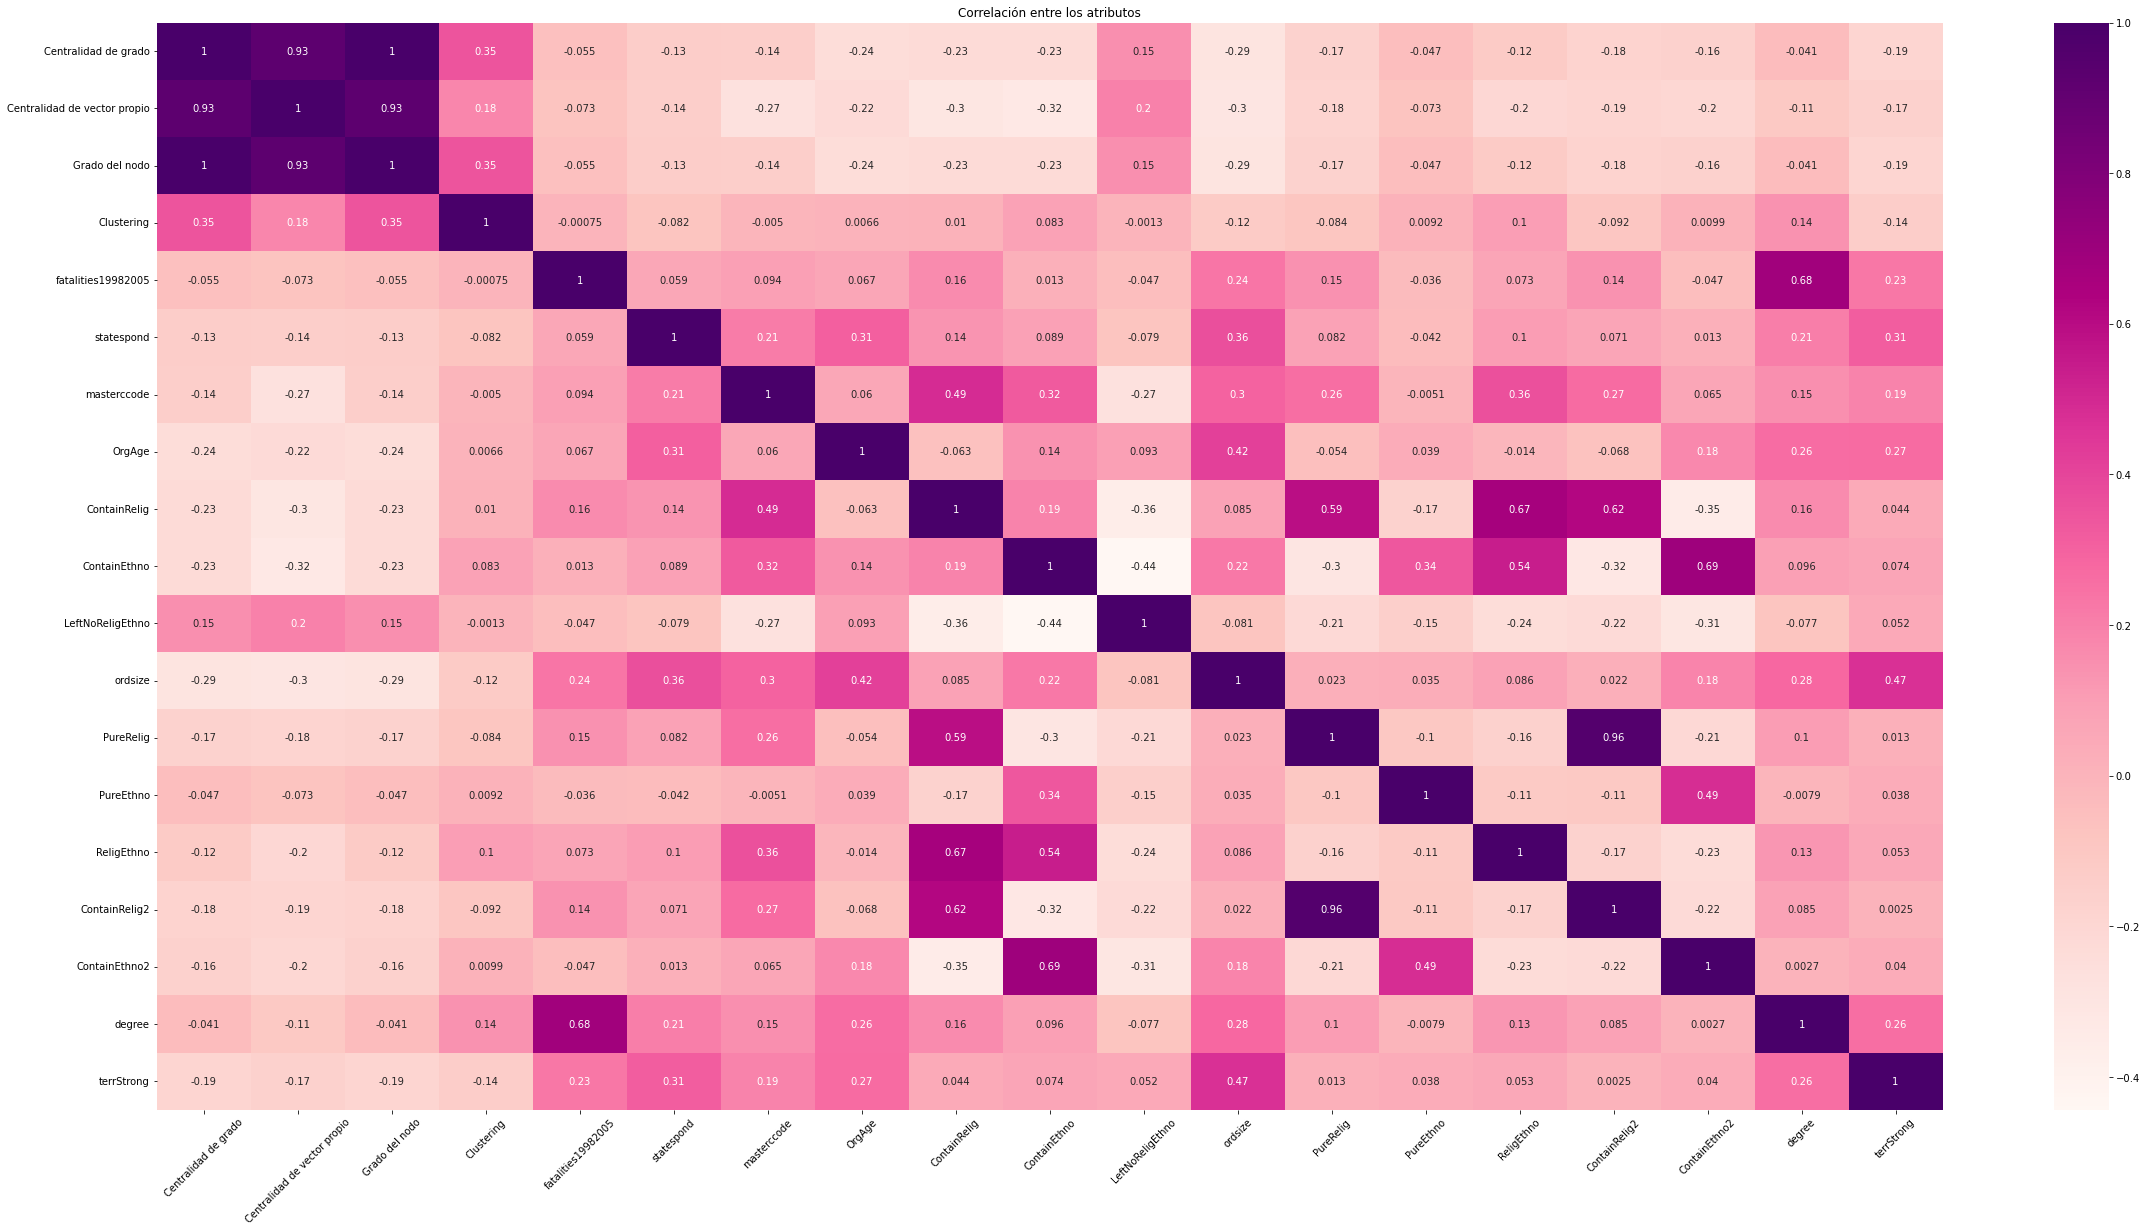

In [27]:
plt.subplots(figsize=(40,20))
gender_correlation=atributos_conjuntos.corr()
sns.heatmap(gender_correlation,annot=True,cmap='RdPu')
plt.title('Correlación entre los atributos')
plt.xticks(rotation=45)

Como se puede observar, los atributos relacionales, exceptuando el clustering están bastante relacionados entre ellos (correlación cercana a 1). Sin embargo, no hay una suficiente fuerza de relacion entre los atributos relacionales y el resto de atributos (correlación cercana a 0). Los atributos originales tampoco están demasiado relacionados entre ellos, excepto los que tienen en cuenta la religion y los que tienen en cuenta la etnia.

## Clasificación

Llamamos a la funciones para clasificar los ejemplos.

### KNn

Realizamos las estimaciones convenientes:

In [28]:
print("Estimación para todos los atributos")
print(estimacion_hiperparametros_knn(atributos_conjuntos_codificados, objetivo_codificado))
print("\nEstimación para los atributos originales")
print(estimacion_hiperparametros_knn(atributos_codificados, objetivo_codificado))
print("\nEstimación sólo para los atributos relacionales")
print(estimacion_hiperparametros_knn(atributos_relacionales_codificados, objetivo_codificado))

Estimación para todos los atributos
{'metric': 'hamming', 'n_neighbors': 28}

Estimación para los atributos originales
{'metric': 'hamming', 'n_neighbors': 7}

Estimación sólo para los atributos relacionales
{'metric': 'euclidean', 'n_neighbors': 10}


Ahora utilizamos los hiper-parámetros estimados.

In [29]:
print("Utilizando todos los atributos")
KNn(28, "hamming", atributos_conjuntos_codificados, objetivo_codificado)
print("\nUtilizando los atributos originales")
KNn(7, "hamming", atributos_codificados, objetivo_codificado)
print("\nUtilizando solo atributos relacionales")
KNn(10, "euclidean", atributos_relacionales_codificados, objetivo_codificado)

Utilizando todos los atributos
Eficiencia: 97.70992366%

Utilizando los atributos originales
Eficiencia: 97.70992366%

Utilizando solo atributos relacionales
Eficiencia: 83.20610687%


### Naive Bayes

Para este modelo, no utilizamos la estimación ya que su único parámetro es el suavizado, que lo dejaremos por defecto (1.0)

In [30]:
print("Utilizando todos los atributos")
naive(atributos_conjuntos_codificados, objetivo_codificado)
print("\nUtilizando los atributos originales")
naive(atributos_codificados, objetivo_codificado)
print("\nUtilizando solo atributos relacionales")
naive(atributos_relacionales_codificados, objetivo_codificado)

Utilizando todos los atributos
Eficiencia: 96.94656488999999%

Utilizando los atributos originales
Eficiencia: 97.70992366%

Utilizando solo atributos relacionales
Eficiencia: 82.44274809%


### Arboles de decisión

Realizamos las estimaciones convenientes

In [31]:
print("Estimación para todos los atributos")
print(estimacion_hiperparametros_cart(atributos_conjuntos_codificados, objetivo_codificado))
print("\nEstimación para los atributos originales")
print(estimacion_hiperparametros_cart(atributos_codificados, objetivo_codificado))
print("\nEstimación sólo para los atributos relacionales")
print(estimacion_hiperparametros_cart(atributos_relacionales_codificados, objetivo_codificado))

Estimación para todos los atributos
{'max_depth': 1}

Estimación para los atributos originales
{'max_depth': 1}

Estimación sólo para los atributos relacionales
{'max_depth': 5}


Ahora utilizamos el hiper-parámetro estimado

Utilizando todos los atributos
Eficiencia: 96.94656488999999%

Utilizando los atributos originales
Eficiencia: 96.94656488999999%

Utilizando solo atributos relacionales
Eficiencia: 80.15267176%


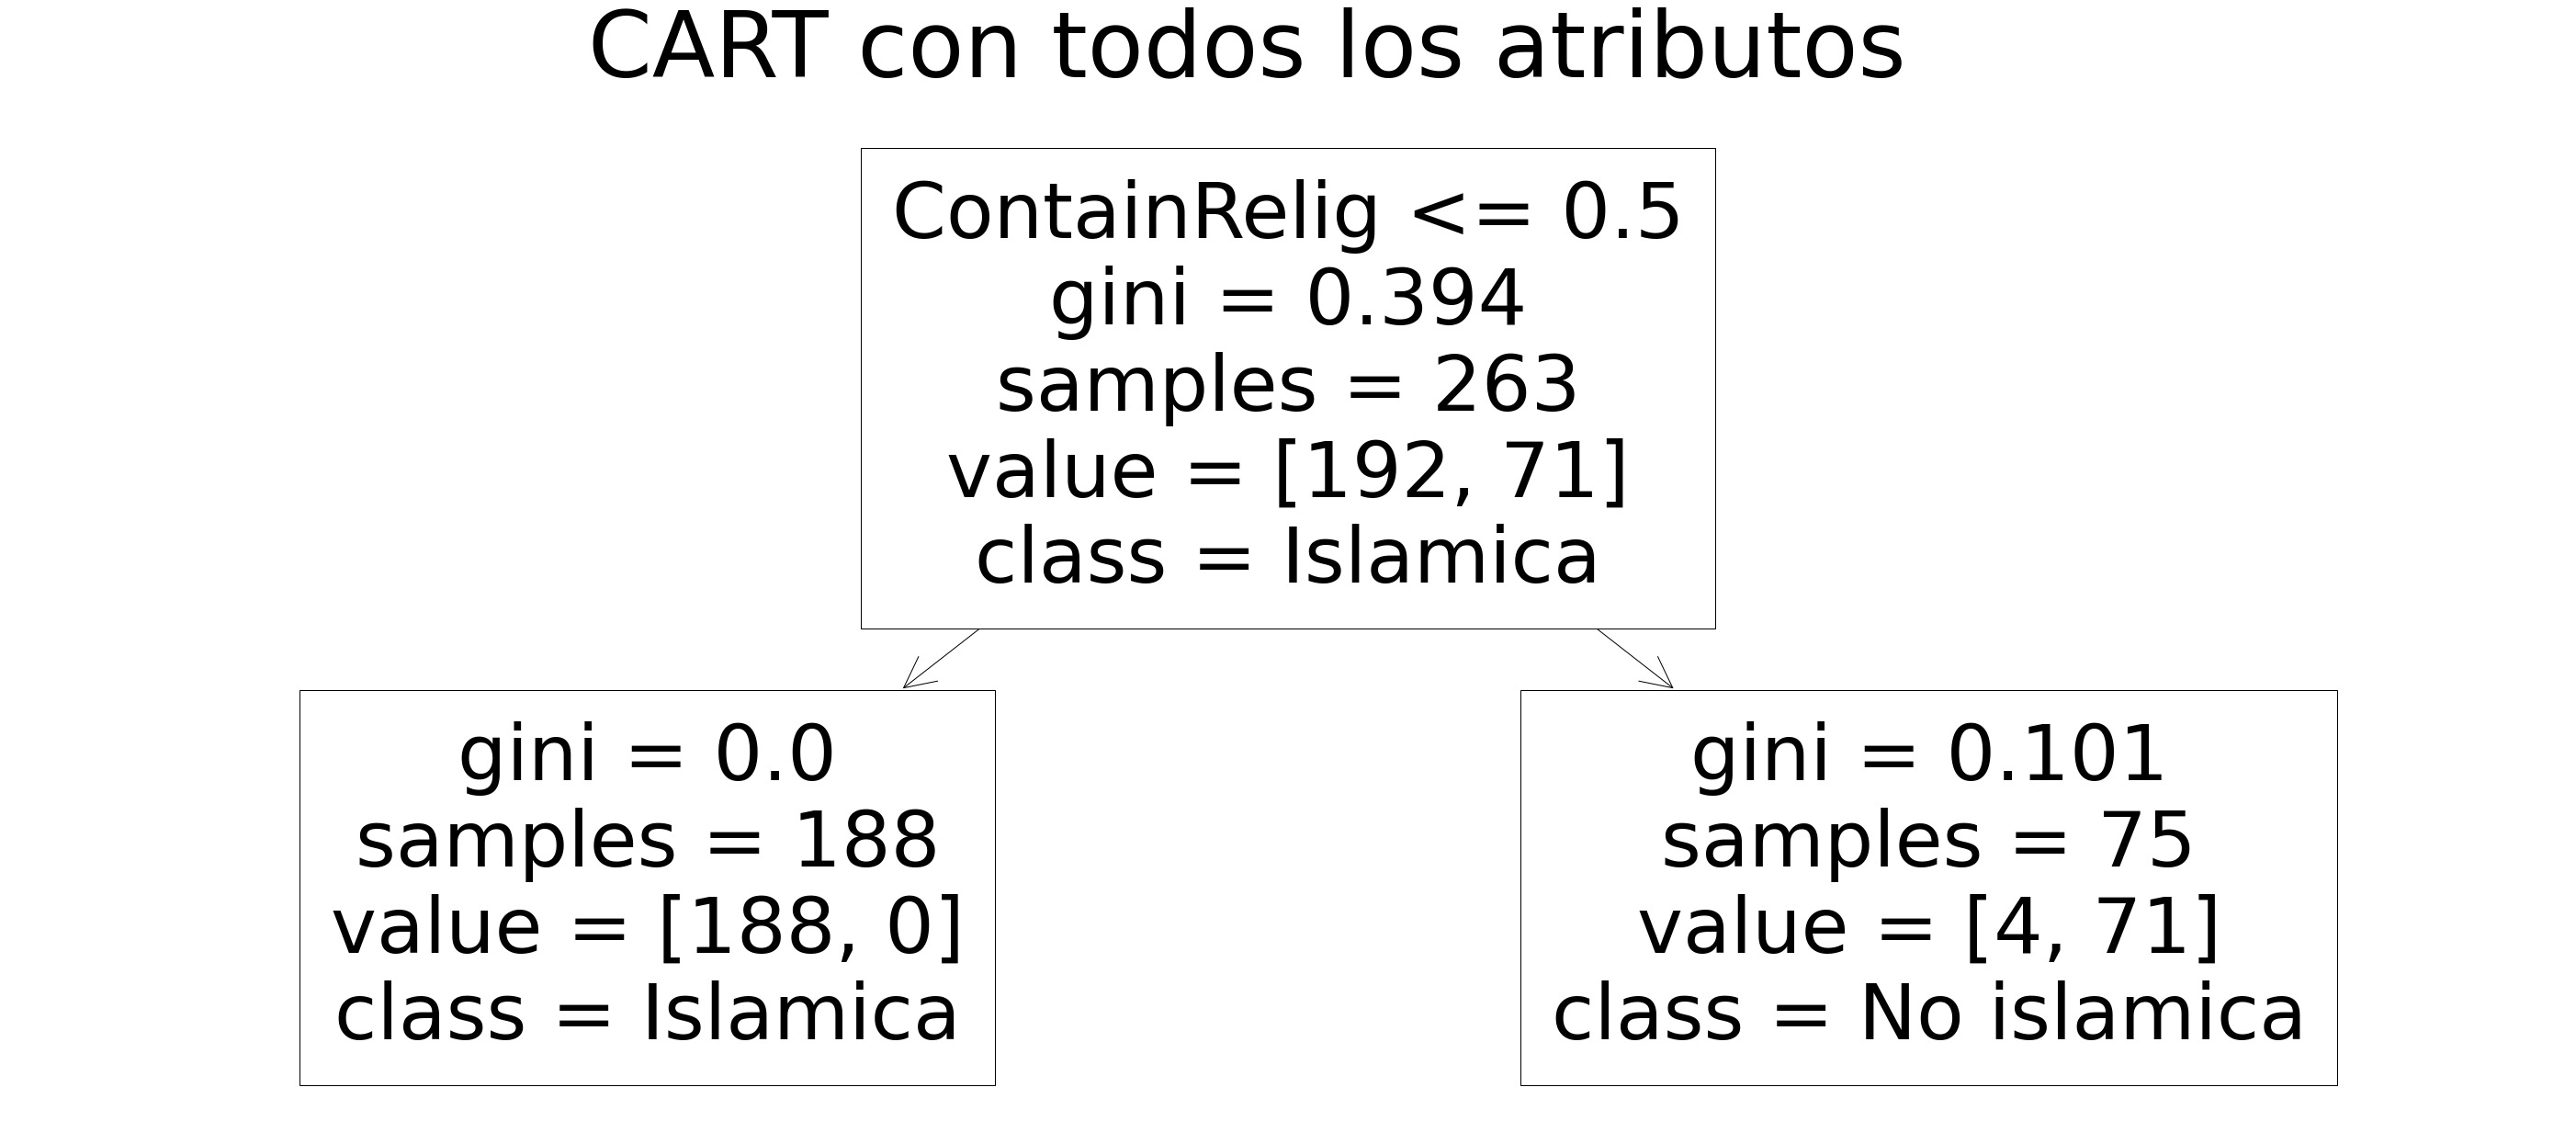

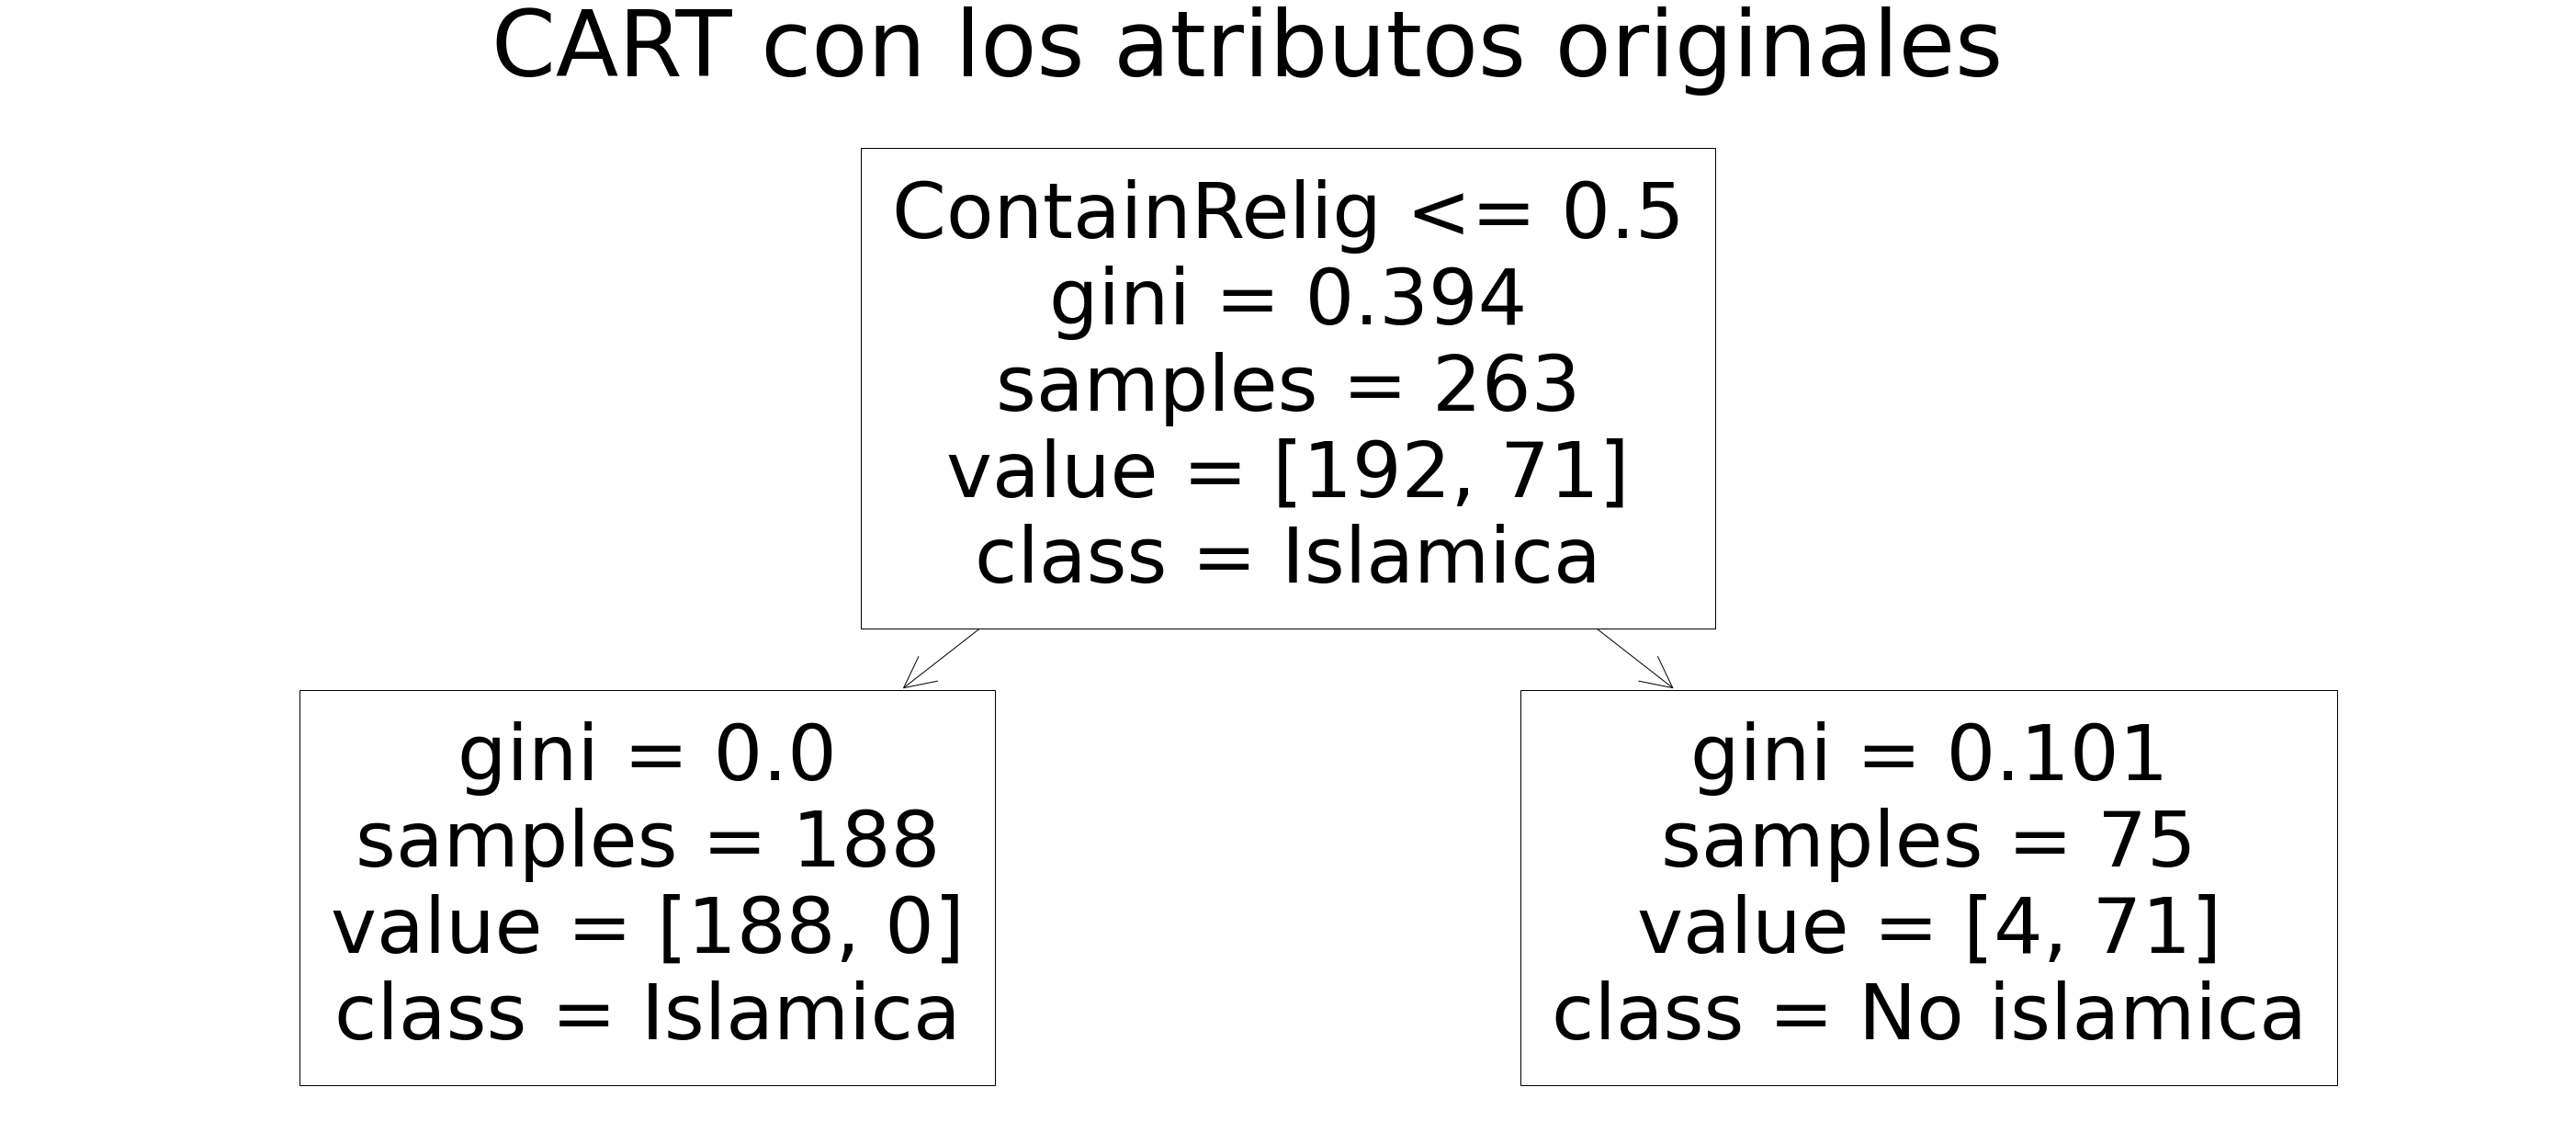

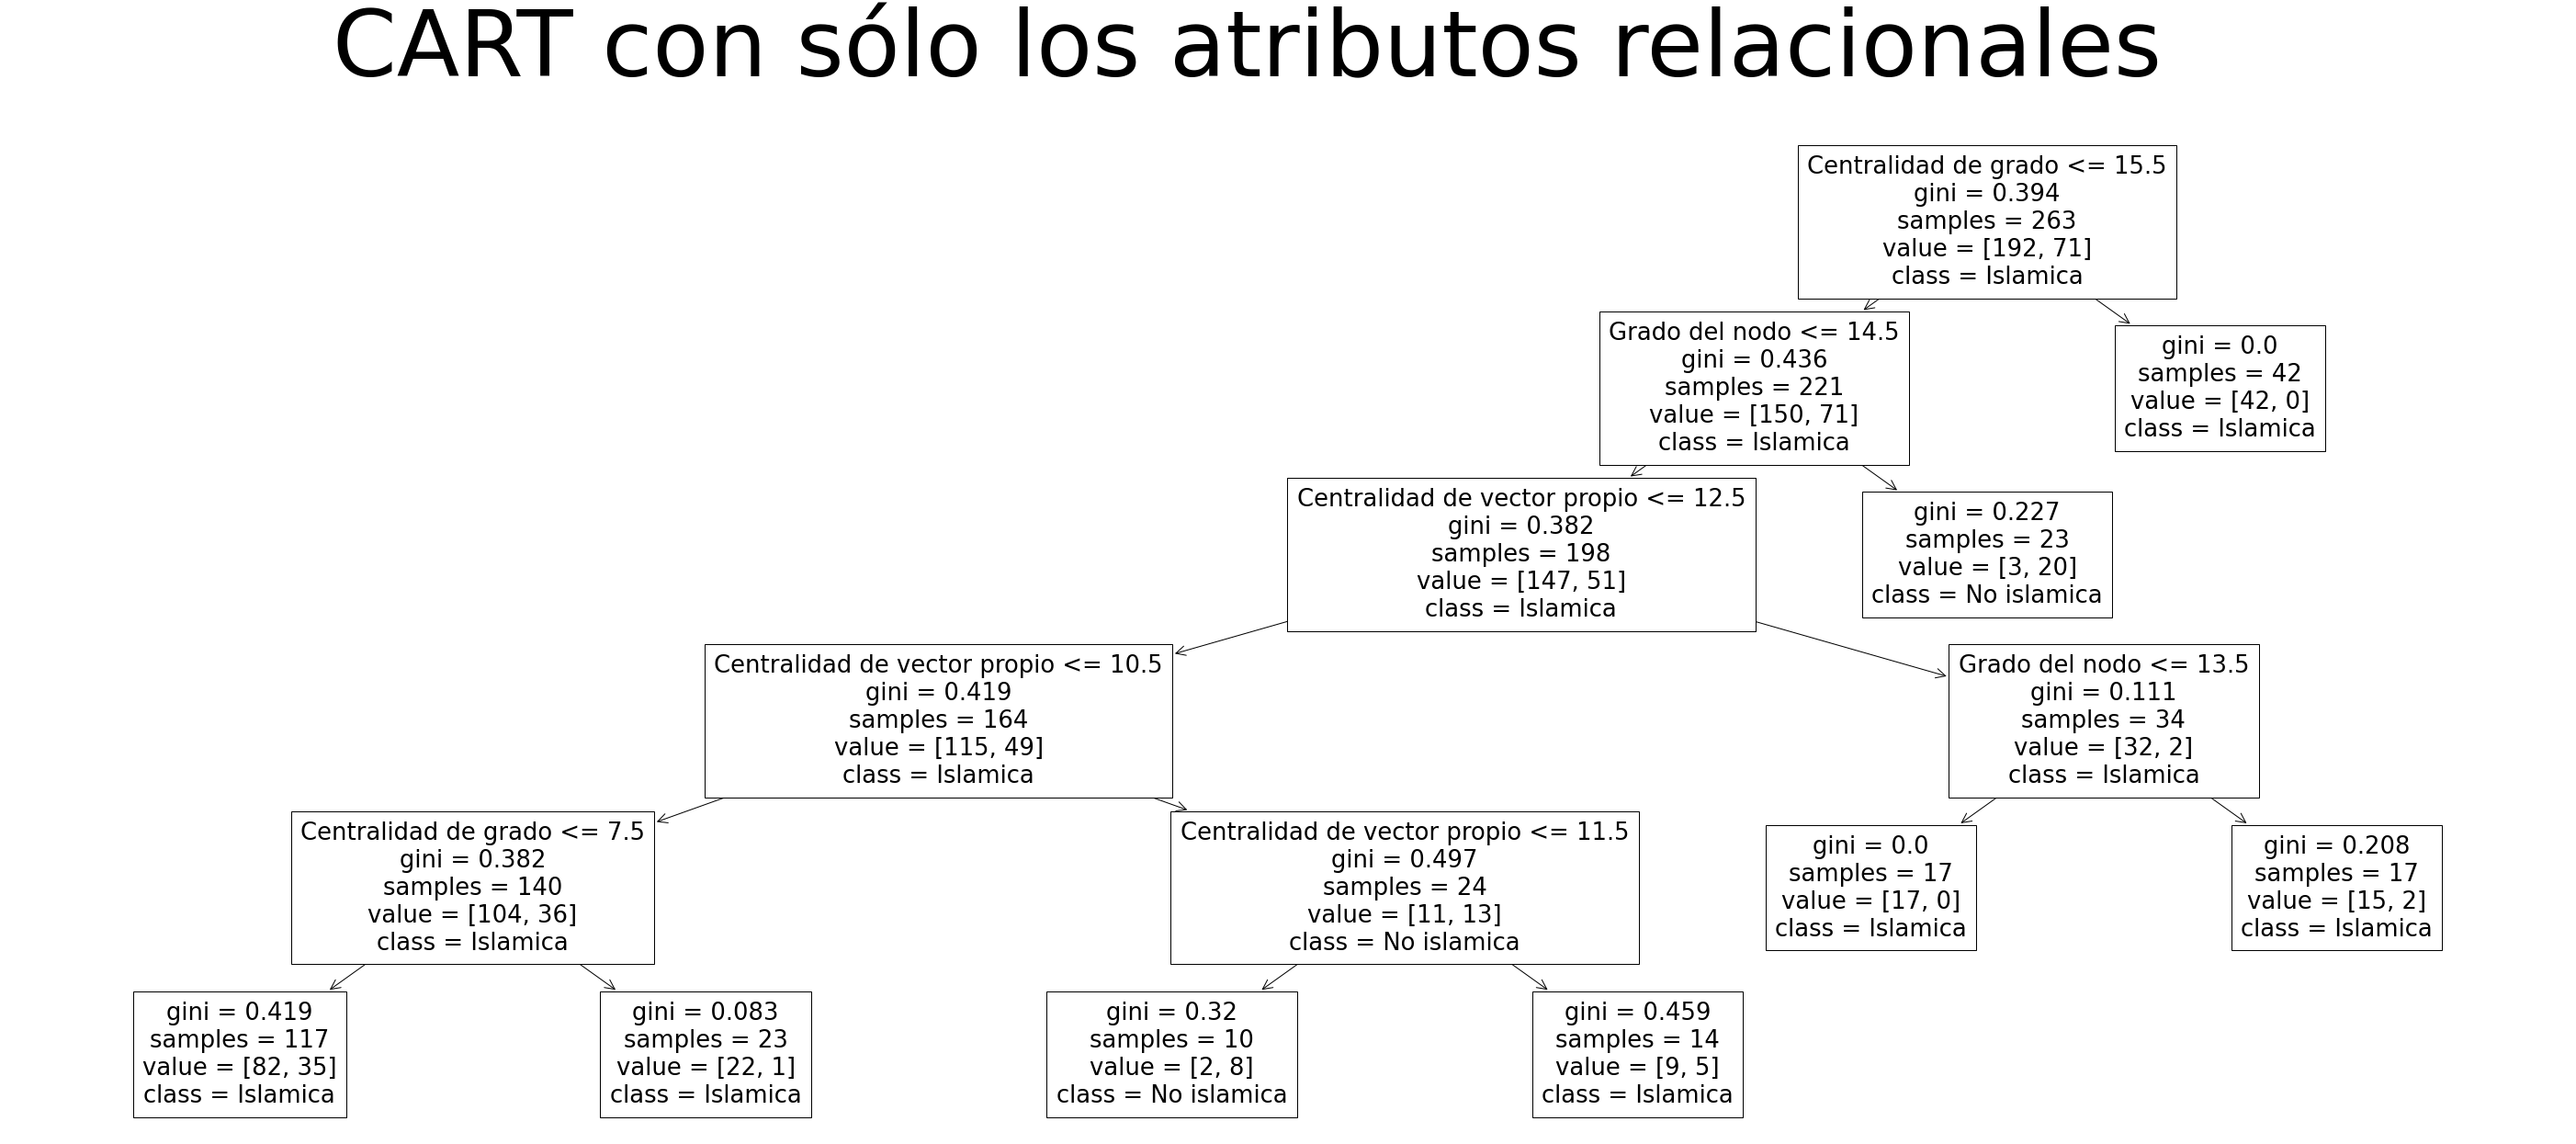

In [32]:
print("Utilizando todos los atributos")
codificador_atributos.fit(atributos_conjuntos)
cart(atributos_conjuntos_codificados, objetivo_codificado, "CART con todos los atributos",1)

print("\nUtilizando los atributos originales")
codificador_atributos.fit(atributos)
cart(atributos_codificados, objetivo_codificado ,"CART con los atributos originales",1)

print("\nUtilizando solo atributos relacionales")
codificador_atributos.fit(atributos_relacionales)
cart(atributos_relacionales_codificados, objetivo_codificado , "CART con sólo los atributos relacionales",5)


## Análisis posterior

Hacemos un análisis posterior de los mejores resultados, en este caso, los obtenemos cuando utilizamos todo el conjunto de atributos, originales y relacionales.

In [33]:
def analisis_residuos(att, obj, tit):
    (atributos_entrenamiento, atributos_validacion,
         objetivo_entrenamiento, objetivo_validacion) = entrenamiento(att, obj)

    modelo = LinearRegression()
    modelo.fit(X = atributos_entrenamiento, y = objetivo_entrenamiento)

    prediccion_train = modelo.predict(atributos_validacion)
    residuos_train   = prediccion_train - objetivo_validacion

    fig, axes = plt.subplots(figsize=(6, 5))

    axes.scatter(prediccion_train, residuos_train,
                       edgecolors=(0, 0, 0), alpha = 0.4)
    axes.axhline(y = 0, linestyle = '--', color = 'black', lw=2)
    axes.set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
    axes.set_xlabel('Predicción')
    axes.set_ylabel('Residuo')
    axes.tick_params(labelsize = 7)
    fig.suptitle(tit, fontsize = 12, fontweight = "bold")

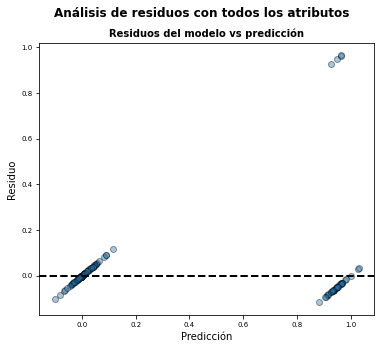

In [34]:
analisis_residuos(atributos_conjuntos_codificados, objetivo_codificado, "Análisis de residuos con todos los atributos")

Como podemos observar, por lo general obtenemos pocas predicciones que se alejen mucho de la línea óptima, por lo que podemos concluir que utilizando todos los atributos tenemos una buena predicción del objetivo del problema.

La entropía cruzada (binaria en este caso) se utiliza habitualmente para cuantificar la diferencia entre dos distribuciones de probabilidad. Ésta es una función de pérdida que se utiliza a menudo en problemas de clasificación.

In [35]:
def entropia_cruzada(att, obj):
    (atributos_entrenamiento, atributos_validacion,
         objetivo_entrenamiento, objetivo_validacion) = entrenamiento(att, obj)

    modelo = LogisticRegressionCV(random_state=0, solver='lbfgs', max_iter=10000)
    modelo.fit(atributos_entrenamiento, objetivo_entrenamiento)

    prediccion_train = modelo.predict(atributos_validacion)
    print(log_loss(prediccion_train, objetivo_validacion))

In [36]:
print("Entropía cruzada")
entropia_cruzada(atributos_conjuntos_codificados, objetivo_codificado)

Entropía cruzada
0.52730956328108


El resultado anterior nos dice lo "equivocada" o "alejada" que está la predicción de la verdadera distribución.

## Conclusiones

Una vez realizadas las lecturas, creacion de grafos correspondientes y definicion de funciones, hemos realizado un análisis previo, donde, en primer lugar hemos definido la estimacion de los diferentes hiper-parámetros de cada modelo. Luego hemos realizado un análisis de la correlación de los atributos, donde afirmamos que los atributos relacionales no tienen fuerza de relación respecto a los atributos originales. Entre los atributos originales tampoco obtenemos una fuerte relacion entre ellos, exceptuando los atributos referentes a la religion y a la etnia.

Despues de haber realizado la clasificacion, teniendo en cuenta las estimaciones y correlación anterior, obtenemos las siguientes conclusiones:

* De forma general, para los modelos KNn y Árbol de decisión, los atributos relacionales no tienen suficiente importancia como para mejorar de forma notable la efectividad de dichos modelos. Sin embargo, para Naive Bayes podemos observar una mejoría más notoria respecto a los atributos originales de 0.76335877%, donde aquí, si se tienen en cuenta los atributos relacionales.

* Teniendo en cuenta los 3 conjuntos de atributos: atributos conjuntos, atributos originales y atributos sólo relacionales; los mejores resultados de clasificación nos lo dá el modelo KNn, y los peores resultados el modelo de Árbol de decisión
* A pesar de que podemos comparar los 3 modelos, de manera general han mostrado un porcentaje de efectividad bastante alto, ninguno bajando del 80%
*Estudiando el análisis posterior concluimos que utilizando todos los atributos(originales y relacionales) en conjunto, tenemos una buena predicción del objetivo del problema.

Código realizado por:
* _Pablo Santos Pérez_
* _Jesús Martín Vergara_